In [ ]:
# Cell 1: Install all dependencies (run once)
!pip install sentence-transformers umap-learn hdbscan scikit-learn transformers dask pandas matplotlib bertopic

In [1]:
# Cell 2: Imports & Seed Themes
import torch
import dask.dataframe as dd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from transformers import pipeline
from collections import defaultdict

# Your domain seed topics:
themes = {
    # Branching narrative and emotional beats
    'story': [
        'story', 'plot', 'narrative', 'pacifist', 'genocide', 'neutral',
        'branching', 'ending', 'choice', 'consequence', 'moral',
        'friendship', 'redemption', 'hope', 'love', 'loss', 'memory',
        'determination'
    ],

    # Cast of monsters, humans, and the player avatar
    'characters': [
        'character', 'frisk', 'chara', 'sans', 'papyrus', 'toriel',
        'asgore', 'alphys', 'undyne', 'mettaton', 'flowey', 'asriel',
        'napstablook', 'monster kid', 'temmie', 'burgerpants',
        'npc', 'relationship', 'backstory'
    ],

    # Core RPG systems and moment‑to‑moment interaction
    'gameplay': [
        'gameplay', 'rpg', 'adventure', 'exploration', 'puzzle',
        'bullet hell', 'dodging', 'timing', 'menu', 'save', 'load',
        'checkpoint', 'inventory', 'quest', 'side quest', 'boss fight'
    ],

    # Turn‑based battles, ACT options, and mercy mechanics
    'combat': [
        'combat', 'battle', 'fight', 'act', 'mercy', 'spare', 'talk',
        'attack', 'defense', 'hp', 'exp', 'lv', 'soul', 'heart',
        'pattern', 'special attack', 'blue soul', 'green soul',
        'orange soul', 'purple soul', 'yellow soul'
    ],

    # Iconic chiptune OST by Toby Fox
    'music': [
        'music', 'soundtrack', 'ost', 'song', 'track', 'theme', 'melody',
        'motif', 'chiptune', 'chip‑tune', 'Megalovania', 'Hopes and Dreams',
        'His Theme', 'Undertale OST', 'piano', '8‑bit', 'orchestral'
    ],

    # Retro pixel art presentation and UI
    'visuals': [
        'visuals', 'graphics', 'sprite', 'pixel art', 'retro', 'color',
        'palette', 'animation', 'effect', 'lighting', 'ui', 'hud',
        'text box', 'portrait', 'scanline', 'CRT'
    ],

    # Signature humor, meta commentary, and fourth‑wall breaks
    'humor_dialogue': [
        'humor', 'dialogue', 'pun', 'joke', 'quirky', 'whimsical',
        'meta', 'fourth wall', 'narrator', 'sarcasm', 'flavor text',
        'reference', 'running gag', 'comic timing'
    ],

    # Moral philosophy, player agency, and in‑game judgment
    'morality': [
        'morality', 'ethics', 'choice', 'consequence', 'violence',
        'mercy', 'guilt', 'atonement', 'judgment hall', 'sins',
        'player agency', 'self‑reflection'
    ],

    # Hidden events, ARG elements, and file manipulation
    'secrets_meta': [
        'secret', 'hidden', 'easter egg', 'gaster', 'fun value',
        'mystery door', 'alternate route', 'hard mode', 'reset',
        'true lab', 'file delete', 'save file', 'corruption',
        'exe', 'meta narrative'
    ],

    # Regions, set pieces, and environmental storytelling
    'world': [
        'world', 'setting', 'underground', 'ruins', 'snowdin',
        'waterfall', 'hotland', 'core', 'new home', 'castle',
        'true lab', 'temmie village', 'river person', 'map',
        'environment', 'atmosphere'
    ]
}



In [2]:
#Cell 3 - Load & Filter reviews
DF_PATH = '../../../parquet_output_indie/391540.parquet'
df = dd.read_parquet(
    DF_PATH,
    columns = ['review', 'votes_up', 'voted_up', 'review_language']
)
df = df[df['review_language'] == 'english'].persist()

In [3]:
#Cell 4 - Sampling function & draw balanced subsets.
def sample_bucket(df, label, n = 50000, random_state=42):
    bucket = df[df['voted_up'] == label][['review', 'votes_up']].dropna()
    total = bucket.shape[0].compute()
    frac = min(1.0, n/total) if total > 0 else 0
    sampled = (bucket.sample(frac=frac, random_state=random_state).compute()
               if frac > 0 else pd.DataFrame(columns=['review', 'votes_up']))
    
    return sampled['review'].tolist(), sampled['votes_up'].tolist()
# likes_docs, likes_votes = sample_bucket(df, True)
# keep dislikes as is, down‑sample likes


dis_docs, dis_votes = sample_bucket(df, False)
likes_docs, likes_votes = sample_bucket(df, True, n=min(10000, 5*len(dis_votes)))


In [4]:
# Cell 5 (or wherever you set up the device/embedder)
device   = 'cuda' if torch.cuda.is_available() else 'cpu'
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

def encode_docs(docs, batch_size=64):
    embs = []
    for i in range(0, len(docs), batch_size):
        embs.append(embedder.encode(docs[i:i+batch_size], convert_to_numpy=True))
    return np.vstack(embs)

all_docs  = likes_docs + dis_docs
likes_emb = encode_docs(likes_docs)
dis_emb   = encode_docs(dis_docs)
all_emb   = np.vstack([likes_emb, dis_emb])


In [6]:
#Cell 6: Fit BERTopic with seep topics
#Prepare seed list in the order of your dict keys

seed_topic_list = list(themes.values())

#Build & fit the model on all docs

# topic_model = BERTopic(
#     embedding_model=embedder,
#     n_gram_range=(1, 2),
#     seed_topic_list=seed_topic_list,
#     representation_model=KeyBERTInspired(),
#     calculate_probabilities=False,
#     verbose=False
# )

# Cell 6 (tuned BERTopic fit) – be sure to include hdbscan in your imports
import hdbscan
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

seed_topic_list = list(themes.values())

topic_model = BERTopic(
    embedding_model      = embedder,
    seed_topic_list      = seed_topic_list,
    n_gram_range         = (1, 2),
    min_topic_size       = 30,     # ↓ default 50
    hdbscan_model        = hdbscan.HDBSCAN(
                              min_cluster_size = 15,   # ↓ default 50
                              min_samples      = 5,
                              metric           = 'euclidean',
                              cluster_selection_method='eom'
                          ),
    representation_model = KeyBERTInspired(),
    verbose              = True
)

topics, _ = topic_model.fit_transform(all_docs, all_emb)

2025-05-04 12:31:22,659 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-05-04 12:31:22,719 - BERTopic - Guided - Completed ✓
2025-05-04 12:31:22,719 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-04 12:31:30,233 - BERTopic - Dimensionality - Completed ✓
2025-05-04 12:31:30,233 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-04 12:31:30,381 - BERTopic - Cluster - Completed ✓
2025-05-04 12:31:30,382 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-04 12:31:32,480 - BERTopic - Representation - Completed ✓


In [7]:
#Cell 7: Extract per-topic keywords, counts & best example
# Build a simple DataFrame to help aggregate

sentiments = ['Like']*len(likes_docs) + ['Dislikes']*len(dis_docs)
df_all = pd.DataFrame({
    "Sentiment": sentiments,
    "TopicID": topics,
    "Review": all_docs,
    "Votes": likes_votes + dis_votes
})

insights = {}
for tid in sorted(set(topics)):
    mask = df_all['TopicID'] == tid
    sub = df_all[mask]
    if tid < 0 or sub.empty:
        continue

    #count & best example

    cnt = len(sub)
    best = sub.loc[sub['Votes'].idxmax(), 'Review']

    #Top Keywords from BERTopic
    kw = [w for w, _ in topic_model.get_topic(tid)][: 10]

    insights[tid] = {
        "Theme": list(themes.keys())[tid] if 0 <= tid < len(themes) else "Other",
        "Count": cnt,
        "Keywords": kw,
        "Example": best
    }
    


In [8]:
#Cell 8: Summarize each example

summarizer = pipeline(
    'summarization',
    model='sshleifer/distilbart-cnn-12-6',
    device=0 if torch.cuda.is_available() else -1
)

def safe_summarize(text):
    try:
        out = summarizer(text, max_length=40, min_length=15, do_sample=False, truncation=True)
        return out[0]['summary_text']
    
    except:
        return text[:200] + '...'
    
for data in insights.values():
    data['Summary'] = safe_summarize(data['Example'] or " ".join(data['Keywords']))

Device set to use cuda:0
Your max_length is set to 40, but your input_length is only 33. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)
Your max_length is set to 40, but your input_length is only 21. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 40, but your input_length is only 24. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)
Your max_length is set to 40, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...'

In [9]:
#Cell 9: Build final DataFrame & display
df_report = pd.DataFrame([
    {
        "Theme": data['Theme'],
        "Cluster (ID)": tid,
        "Count": data['Count'],
        "Keywords": ", ".join(data['Keywords']),
        "Example Review": data['Example'],
        "Summary": data['Summary']
    }
    for tid, data  in insights.items()
])

display(
    df_report.style
    .set_caption("BERTopic-guided Review Insights")
    .hide(axis="index")
)

Theme,Cluster (ID),Count,Keywords,Example Review,Summary
story,0,1860,"undertale is, undertale, rpg, gameplay, games, game, the game, play, this game, character","[b] If you enjoy this review please consider following my Curator page [url=http://store.steampowered.com/curator/31067175-ParanoidAndroid-Picks/] here [/url]. [/b] So after the overwhelming hype I decided to give Undertale a try, and I have to say I didn't really enjoy it. I see the appeal of it and understand why some people like it but it's just not for me. If I'm being brutally honest, this games feels like its being aimed at highschool-aged kids who think it's so funny to be ""random"" and love memes. I'm not trying to be highbrow but the humor absolutely did not click with me. Aside from a chuckle or two, I found most of the humor pretty grating and swinging at low-hanging fruit. Because I didn't really like the writing, I found the characters to be much less endearing than many others. As far as the gameplay goes, it does turn the genre on its ear by introducing the bullet hell-styled fights. Unfortunately, I'm not a fan of bullet hell games. I can appreciate the novelty and attempt at doing something different but like the writing, it just wasn't for me. Story-wise and emotionally, the game didn't really move the needle for me. I never got invested in the characters and overall the game simply did not click with me. I really am disappointed that I did not enjoy it because To the Moon and LISA are some of my favorite games, with the latter (in my mind) superior in every way the Undertale. If there's one thing I really did like it would be the music. I don't normally write negative reviews, but I wanted to for this game just in case there is someone who has the same tastes as I do and doesn't get swept up in the hype storm that is Undertale. **EDIT: Because people have asked, yes I beat the game on a true pacifist run.**","After the overwhelming hype I decided to give Undertale a try, and I have to say I didn't really enjoy it . I see the appeal of it and understand why some people like"
characters,1,321,"story game, amazing game, great game, game great, awesome game, good game, great story, characters great, best story, fun story","Nope. Sorry boys, I like Lisa more. Not for me. Definitely try this game though, lots of people connect with it.","Sorry boys, I like Lisa more . Not for me. Not for Lisa . Definitely try this game ."
gameplay,2,243,"best game, greatest game, game best, best games, favorite game, best gamebest, favourite game, greatest games, favorite games, game ever",JESUS THIS GAME IS SO MUCH BETTER THAN YOU COULD EVER IMAGINE,"JESUS THIS GAME IS SO much BETTER THAN YOU COULD EVER IMAGINE. JESU: ""This game is so much better than you could ever imagine."
combat,3,240,"gameplay, combat, the combat, battle, boring, combat is, game is, game, play, the game",Didn't really engage me. The humor fell flat for me (I fully realize that may be more me than the game) I really didn't care about any of the characters (again that's probably me) I liked the combat and found it unique but it started to get annoying later into the game. Not bad but nowhere near the level of hype it was given.,The humor fell flat for me (I fully realize that may be more me than the game) I liked the combat and found it unique but it started to get annoying later into the game
music,4,203,"music great, great music, great soundtrack, great characters, characters great, good music, game great, game amazing, amazing game, amazing music","Incredible game. The less you know / read about this game, the better. Just go play it. Completely worth it, even at full price. Games with this much heart and such an incredible story are few and far between. This belongs among games like To The Moon, Finding Paradise, and Doki Doki Literature Club. Amazing. You'll be listening to its soundtrack for days afterwards. And, as always, stay determined!","The less you know / read about this game, the bett

<Figure size 1000x600 with 0 Axes>

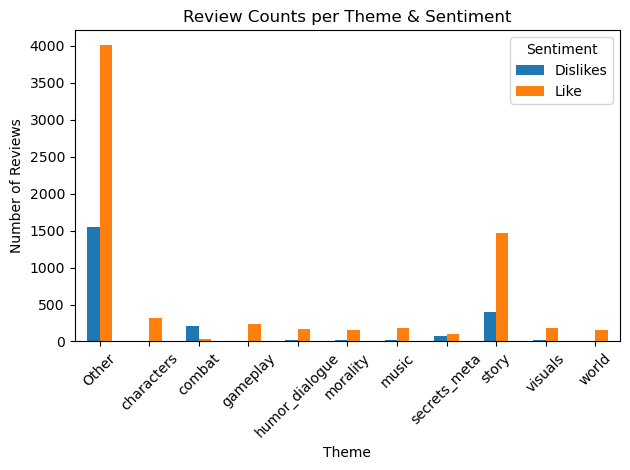

In [10]:
# Cell 10: Plot review counts by theme & sentiment
plt.figure(figsize=(10,6))
plot_df = df_all.merge(df_report[['Cluster (ID)','Theme']], 
                      left_on='TopicID', right_on='Cluster (ID)', how='inner')
plot_df.groupby(['Theme','Sentiment'])['Review'] \
       .count() \
       .unstack('Sentiment') \
       .plot(kind='bar', rot=45)
plt.title("Review Counts per Theme & Sentiment")
plt.xlabel("Theme")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()